In [1]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import logger
import xesmf as xe
from scipy.ndimage import label

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import regionmask

import climtas.nci
from dask.distributed import Client, as_completed

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [2]:
LOG = logger.get_logger(__name__)

In [3]:
ds_mean = xr.open_dataset('/g/data/er8/users/cd3022/solar_drought/himawari_irradiance_means/total_mean.nc')

In [4]:
seasons = {
    'summer':[1,2,12],
    'autumn':[3,4,5],
    'winter':[6,7,8],
    'spring':[9,10,11]
} 
season = 'winter'
year=2016
files = []

for int_month in seasons[season]:
    month = f'{int_month}'
    date_dt = datetime.strptime(f'{month}-{year}', "%m-%Y")

    
    ##### Himawari Data
    if date_dt <= datetime.strptime('2019-03-31', '%Y-%m-%d'):
        version = 'v1.0'
    else:
        version = 'v1.1'
    directory=Path(f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1d/{version}/{year}/{month}')
    files.extend(sorted(str(p) for p in directory.rglob("*.nc")))

In [5]:
print(files)

[]


In [6]:
def _preprocess(ds):
    return ds.drop_vars(set(ds.data_vars) - {'daily_integral_of_surface_global_irradiance'})
def drought_metrics(year, season, var):

    seasons = {
        'summer':[1,2,12],
        'autumn':[3,4,5],
        'winter':[6,7,8],
        'spring':[9,10,11]
    } 
    files = []

    for int_month in seasons[season]:
        month = f"{int_month:02d}"
        date_dt = datetime.strptime(f'{month}-{year}', "%m-%Y")

        
        ##### Himawari Data
        if date_dt <= datetime.strptime('2019-03-31', '%Y-%m-%d'):
            version = 'v1.0'
        else:
            version = 'v1.1'
        directory=Path(f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1d/{version}/{year}/{month}')
        files.extend(sorted(str(p) for p in directory.rglob("*.nc")))
    
    # LOG.info(f'opening files: {files}')
    
    himawari = xr.open_mfdataset(
        files,
        combine='by_coords',
        preprocess=_preprocess,
        engine='h5netcdf',
    )
    LOG.info('OPEN HIMAWARI')
    himawari = himawari.chunk({'time':-1})

    threshold = 0.5
    data = himawari.daily_integral_of_surface_global_irradiance
    mean = ds_mean.daily_integral_of_surface_global_irradiance
    droughts = xr.where(data < (threshold * mean), 1, 0)

    _MAX_EVENTS = 100 # so the compute_durations function outputs arrays of equal length
    # Get drought lengths
    def compute_durations(da):
        labels, num = label(da)
        durations = np.array([(labels == i).sum() for i in range(1, num + 1)], dtype=np.int32)
        padded = np.full((_MAX_EVENTS,), fill_value=np.nan, dtype=np.float32)
        padded[:len(durations)] = durations[:_MAX_EVENTS]
        return padded

    # creates an array of "drought" durations
    durations = xr.apply_ufunc(
        compute_durations,
        droughts,
        input_core_dims=[['time']],
        output_core_dims=[['event']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float32],
        output_sizes={'event': _MAX_EVENTS},
    )
    
    # events normally defined using duration >= 3, but this may not be appropriate for solar
    # see https://climpact-sci.org/indices/ for more details
    if var == 'amp':
        return data.min(dim='time')
    if var == 'dur':
        return durations.max(dim='event', skipna=True)
    if var == 'freq':
        return droughts.sum(dim='time')
    if var == 'num': 
        return xr.where(durations > 0, 1, 0).sum(dim='event')
    if var == 'mean':
        drought_data = xr.where(data < (threshold * mean), data, np.nan)
        return drought_data.mean(dim='time', skipna=True)

In [7]:
# Step 1: Create binary mask
data = [0,1,1,1,1,0,1,1,0,1,0,0,0,1,1,1, 0, 1, 0, 1, 0, 1, 1, 1]
time= np.linspace(1,len(data), len(data))
my_da = xr.DataArray(data, coords={'time':time})

# Step 2: Function to compute durations along 1D time axis
def compute_durations(mask_1d):
    labels, num = label(mask_1d)
    return np.array([(labels == i).sum() for i in range(1, num + 1)], dtype=np.int32)

# Step 3: Apply function along 'time' axis using apply_ufunc
durations = xr.apply_ufunc(
    compute_durations,
    my_da,
    input_core_dims=[['time']],
    output_core_dims=[['event']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.int32],
)

In [8]:
client = Client(
    n_workers=24,
    threads_per_worker=1
)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 24
Total threads: 24,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44099,Workers: 24
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:35707,Total threads: 1
Dashboard: /proxy/33489/status,Memory: 3.96 GiB
Nanny: tcp://127.0.0.1:35967,


2025-06-08 15:10:59,424 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-06-08 15:11:20,890 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-06-08 15:11:55,378 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-06-08 15:12:48,325 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-06-08 15:12:52,243 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-06-08 15:12:58,272 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-06-08 15:13:23,156 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2025-06-08 15:13:56,355 - distributed.utils_perf - WARNING - full garbage collections took

In [16]:
variables = [
    'freq',
    'amp',
    'dur',
    'mean',
    'num',
]
seasons = [
    'summer',
    'autumn',
    'winter',
    'spring',
]

#########################

if __name__ == '__main__':
    for var in variables:
        for season in seasons:
            futures = {}
            
            for year in range(2016, 2025):
                future = client.submit(drought_metrics, year, season, var)
                futures[future] = year
                
            results = []
            for future in as_completed(futures):
                res = future.result()
                results.append(res)
        
            results_combined = xr.concat(results, dim='date')
            metric = results_combined.mean(dim='date', skipna=True)

            file_path = Path('/g/data/er8/users/cd3022/solar_drought/regional_metrics/')
            file_name = f'{var}_{season}.nc'
            os.makedirs(file_path, exist_ok=True)
            metric.to_netcdf(f'{file_path}/{file_name}')

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed
INFO:__main__:OPEN HIMAWARI
/jobfs/142607143.gadi-pbs/ipykernel_1257228/2033916554.py:52: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
INFO:__main__:OPEN HIMAWARI
/jobfs/142607143.gadi-pbs/ipykernel_1257228/2033916554.py:52: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
INFO:__main__:OPEN HIMAWARI
/jobfs/142607143.gadi-pbs/ipykernel_1257228/2033916554.py:52: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
INFO:__main__:OPEN HIMAWARI
/jobfs/

In [10]:
# variables = [
#     # 'freq',
#     # 'amp',
#     'dur',
#     # 'mean',
#     # 'num',
# ]
# seasons = {
#     # 'summer':[1,2,12],
#     # 'autumn':[3,4,5],
#     'winter':[6,7,8],
#     # 'spring':[9,10,11]
# }
# ############
# # CURRENT METHOD OF TAKING MEAN OVER SEASON THEN SUMMING DOES NOT WORK FOR ALL
# # METRICS, NEED TO TREAT EACH METRIC DIFFERENTLY
# ###########
# if __name__ == '__main__':
#     for var in variables:
#         for season in seasons:
#             futures = {}
#             total = []
#             for year in range(2016, 2025):
#                 for month in seasons[season]:
#                     date = f'{month}-{year}'
#                     future = client.submit(drought_metrics, date, var)
#                     futures[future] = date
                
#                 seasonal_results = []
#                 labels = []
#                 for future in as_completed(futures):
#                     result = future.result()
#                     seasonal_results.append(result)
#                     labels.append(futures[future])
                
#                 combined_season = xr.concat(seasonal_results, dim='date')
#                 season_total = combined_season.sum(dim='date', skipna=True)
#                 total.append(season_total)
        
#             combined_total = xr.concat(total, dim='year')
#             metric = combined_total.mean(dim='year', skipna=True)
        
#             file_path = Path('/g/data/er8/users/cd3022/solar_drought/regional_metrics/')
#             file_name = f'{var}_{season}.nc'
#             os.makedirs(file_path, exist_ok=True)
#             # metric.to_netcdf(f'{file_path}/{file_name}')

2025-06-08 14:44:41,597:py.warnings:WARNING: /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 45.38 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(

This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(



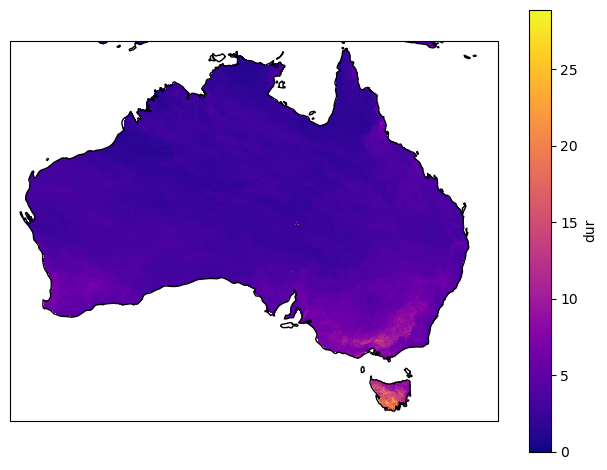

In [15]:
land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(metric)
data_landonly = metric.where(land_mask == 0)

latitudes = metric.latitude
longitudes = metric.longitude
data = data_landonly.values

# Create a figure
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

mesh=ax.pcolormesh(longitudes, latitudes, data, cmap='plasma',vmin=0,  transform=ccrs.PlateCarree())

ax.coastlines()
cbar = plt.colorbar(mesh,ax=ax)
# cbar.ax.tick_params(labelsize=5)  # Set the font size for the colorbar ticks
cbar.set_label(f'{var}') 
 
plt.tight_layout()

plt.show()